# Import necessery libraries

In [ ]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
import numpy as np
import pandas as pd
from glob import glob

# Load filepath and set constant image size

In [ ]:
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/My Drive/datasets/Plants/Potato/train'
validation_path = '/content/drive/My Drive/datasets/Plants/Potato/valid'

# Check data path to know how many categories impoved

In [ ]:
from glob import glob
folders = glob('/content/drive/My Drive/datasets/Plants/Potato/train/*')
folders

['/content/drive/My Drive/datasets/Plants/Potato/train/Potato___Early_blight',
 '/content/drive/My Drive/datasets/Plants/Potato/train/Potato___Late_blight',
 '/content/drive/My Drive/datasets/Plants/Potato/train/Potato___healthy']

# Observe the data in the dataset
It is important to observe how th data is distributed across all categories. This is to know if you are working with balanced or imbalanced dataset

In [ ]:
def observe_data(fpath):
  import os
  import pandas as pd
  import matplotlib.pyplot as plt

  data = {}

  plant_classes = [x[0] for x in os.walk(fpath) ]
  for fpath in plant_classes[1:]:
    items = os.listdir(fpath)
    data[fpath.split('___')[-1]] = len(items)
    
  df = pd.DataFrame(list(data.items() ), columns=['class', 'number of images'])

  plt.bar(df['class'], df['number of images'], color='rgbkymc')
  for index, value in enumerate(df['number of images']):
      s = '{}'.format(value)
      plt.text(index,value , str(s), fontsize=8)
  plt.xticks(rotation=90)
  plt.show()
  return df


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  from ipykernel import kernelapp as app


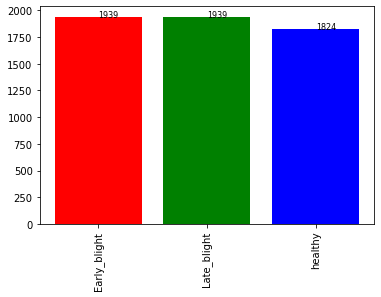

In [ ]:
df = observe_data(train_path)

# Using a pretrained network to build the model
## Instantiating the inception V3 convolutional base

In [ ]:
inception_conv_base = InceptionV3(input_shape= IMAGE_SIZE + [3],
                        weights='imagenet',
                        include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


## Freezing the Layers
This is to prevent the weight of the layers from updating during training. If this is not done, the representations that were previously learned by the convolutional base will be modified during training

In [ ]:
for layer in inception_conv_base.layers:
  layer.trainable=False

## Flatten the model and create the ouput layer

In [ ]:
model = Sequential()
model.add( inception_conv_base )
model.add( Flatten() )
model.add( Dense(len(folders), activation='softmax') )

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 3)                 153603    
Total params: 21,956,387
Trainable params: 153,603
Non-trainable params: 21,802,784
_________________________________________________________________


## Set the model optimizer

In [ ]:
model.compile( loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

## input processing and image argumentation 


In [ ]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)

# Validation set should not be argumented
test_datagen = ImageDataGenerator(rescale=1./255)

# Train generator

In [ ]:
train_generator = train_datagen.flow_from_directory(
                train_path,                  # target directory
                target_size=IMAGE_SIZE,      # resize image to 224 x 224
                batch_size=20,
                class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
                validation_path,
                target_size=IMAGE_SIZE,
                batch_size=20,
                class_mode='categorical')

Found 5702 images belonging to 3 classes.
Found 1426 images belonging to 3 classes.


# Train the model

In [ ]:
%time
from time import time

start = time()

history = model.fit_generator(
            train_generator,
            validation_data=validation_generator,
            epochs=20,
            steps_per_epoch=len(train_generator),
            validation_steps=len(validation_generator))

# save model
base_dir = '/content/drive/My Drive/datasets/Plants/Potato'
model.save(base_dir + '/potato_inception_v3_2.h5')

print('\n\nDuration: {} seconds'.format(time() - start))


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 16.7 µs
Found 5702 images belonging to 3 classes.
Found 1426 images belonging to 3 classes.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
286/286 [==============================] - 2344s 8s/step - loss: 1.6716 - accuracy: 0.8201 - val_loss: 0.7571 - val_accuracy: 0.9088
Epoch 2/20
286/286 [==============================] - 84s 292ms/step - loss: 1.1234 - accuracy: 0.8876 - val_loss: 1.9596 - val_accuracy: 0.8366
Epoch 3/20
286/286 [==============================] - 82s 285ms/step - loss: 1.1985 - accuracy: 0.9009 - val_loss: 0.5135 - val_accuracy: 0.9453
Epoch 4/20
286/286 [==============================] - 79s 276ms/step - loss: 1.1220 - accuracy: 0.9142 - val_loss: 0.5879 - val_accuracy: 0.9425
Epoch 5/20
286/286 [==============================] - 79s 278ms/step - loss: 0.8374 - accuracy: 0.9309 - val_loss: 0.8186 - val_accuracy: 0.9306
Epoch 6/20
286/286 [==============================] 

## Plot

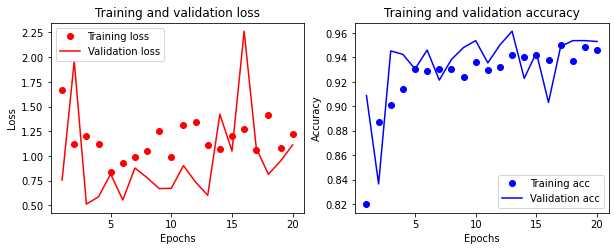

In [ ]:
def plot_history(history):
    import pandas as pd
    import matplotlib.pyplot as plt
    history_dict = history.history
    df = pd.DataFrame(history_dict)

    plt.rcParams['figure.figsize'] = [10, 3.5]
    fig, axs = plt.subplots(1, 2)
    plt.subplots_adjust(hspace=0.5, wspace=0.2)
    p1, p2 = axs[0], axs[1]

    epochs = range(1, len(df.index) + 1)
    p1.plot(epochs, df[df.columns[0]], 'ro', label='Training loss')
    p1.plot(epochs, df[df.columns[2]], 'r', label='Validation loss')
    p1.set_title('Training and validation loss')
    p1.set_xlabel('Epochs')
    p1.set_ylabel('Loss')
    p1.legend()

    p2.plot(epochs, df[df.columns[1]], 'bo', label='Training acc')
    p2.plot(epochs, df[df.columns[3]], 'b', label='Validation acc')
    p2.set_title('Training and validation accuracy')
    p2.set_xlabel('Epochs')
    p2.set_ylabel('Accuracy')
    p2.legend()

    plt.show()

plot_history(history)

# Load Model

In [ ]:
%time
from tensorflow.keras.models import Sequential, save_model, load_model
import numpy as np

IMAGE_SIZE = [224, 224]
filepath = '/content/drive/My Drive/datasets/Plants/Potato/potato_inception_v3.h5'

model = load_model(
    filepath,
    custom_objects=None,
    compile=True)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [ ]:
from glob import glob
folders = glob('/content/drive/My Drive/datasets/Plants/Potato/train/*')
labels = [ x.split('___')[-1] for x in folders]
labels

['Early_blight', 'Late_blight', 'healthy']

# Testing the what thw model accuracy looks like

In [ ]:
import os
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

IMAGE_SIZE = [224, 224]
batch_size = 15
test_path = "/content/drive/My Drive/datasets/Plants/Potato/valid/Potato___Early_blight"

test_filenames = os.listdir(test_path)
test_df = pd.DataFrame({'filename': test_filenames})

nb_samples = test_df.shape[0]

test_gen = ImageDataGenerator(rescale=1./255)

test_set = test_gen.flow_from_dataframe(
    test_df, 
    test_path, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False)

Found 485 validated image filenames.


# Predict

In [ ]:
predict = model.predict_generator(test_set, steps=np.ceil(nb_samples/batch_size))

Instructions for updating:
Please use Model.predict, which supports generators.


In [ ]:
test_df['raw_category'] = 0
test_df['category'] = np.argmax(predict, axis=-1)

for i in range(len(test_df)):
  x = test_df['category'].iloc[i]
  test_df['raw_category'].iloc[i] = predict[i][x]
# test_df['raw_category'] = test_df['category'].apply(lambda x: predict[x])
test_df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,filename,raw_category,category
0,1082eee1-189d-4e0f-96b5-8b1393be4c4c___RS_Earl...,1.0,0
1,07d777f8-2c5a-48da-935e-f17c572b1e6e___RS_Earl...,1.0,0
2,08a892eb-19cc-45ea-babc-181b98f89238___RS_Earl...,1.0,0
3,1367d3e9-74fe-4d61-ab24-dd389dcb5d54___RS_Earl...,1.0,0
4,10a3920b-dd04-406d-8bbd-f92f221e4dee___RS_Earl...,1.0,0


In [ ]:
test_df.category.value_counts()

0    470
1     11
2      4
Name: category, dtype: int64

In [ ]:
test_df.raw_category.min()

0.6438615322113037

In [ ]:
fil = test_df['category'] != 0
test_df[ fil ].head(20)

,filename,raw_category,category
52,49ecf1fe-0000-49e8-a042-fb6c9bac38c9___RS_Earl...,1.000000,1
171,65f6e2f1-300b-42f0-bcc8-467753411947___RS_Earl...,0.999130,1
177,77725a5a-c0b8-4b7c-bc42-ac99f51428c1___RS_Earl...,1.000000,1
212,593de3cd-1e2e-4943-b5f3-ef9d5d857894___RS_Earl...,0.643862,2
230,a29559c6-1d80-4486-a3c9-26986d6e28e0___RS_Earl...,1.000000,2
256,b6b036b0-6869-48b8-b861-a6a85d1b2b97___RS_Earl...,1.000000,2
268,c5cb3e89-f00f-4032-80ca-eb39bead0796___RS_Earl...,1.000000,1
278,bcedd1ec-17b4-495b-b47f-5877ef836f88___RS_Earl...,0.905765,1
279,bcedd1ec-17b4-495b-b47f-5877ef836f88___RS_Earl...,0.870250,1
284,acff9d5e-4b38-4817-a239-93c115a0b3ff___RS_Earl...,1.000000,1


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model
from keras.preprocessing.image import load_img

def show_img(test_df, fil):
  """
  """

  sample_test = test_df[fil].head(18)
  sample_test.head()
  plt.figure(figsize=(12, 24))

  i = 0
  for index, row in sample_test.iterrows():
      i += 1

      filename = row['filename']
      category = row['raw_category']
      c = row['category']

      if category >= 0.5:
          animal = 'Dog'
      else:
          animal = 'Cat'

      # print(index)
      img = load_img(test_path + '/' + filename, target_size=IMAGE_SIZE)
      plt.subplot(6, 3, i)
      plt.imshow(img)
      plt.xlabel(f'{filename.split(" ")[-1]} \n{labels[c]}' + '- (' + "{:.2f}".format(category) + ')' )
  plt.tight_layout()
  plt.show()

In [ ]:
# fil = (test_df['raw_category'] > 0.5) & (test_df['raw_category'] < 0.9)
fil = test_df['category'] != 0

plot(test_df, fil)

Output hidden; open in https://colab.research.google.com to view.